In [1]:
import os
img_shape = (28, 28, 1)

batch_size = 64
epochs = 100

In [2]:
base_output = "output"

model_path = os.path.sep.join([base_output, "siamese_model"])
plot_path = os.path.sep.join([base_output, "plot.png"])

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D

In [4]:
def build_siamese_model(inputShape, embeddingDim=48):
  inputs = Input(inputShape)

  x = Conv2D(64, (2, 2), padding="same", activation="relu")(inputs)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = Dropout(0.3)(x)
  x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
  x = MaxPooling2D(pool_size=2)(x)
  x = Dropout(0.3)(x)

  pooledOutput = GlobalAveragePooling2D()(x)
  outputs = Dense(embeddingDim)(pooledOutput)
  model = Model(inputs, outputs)
  return model

In [5]:
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np

In [6]:
def make_pairs(images, labels):

  pairImages = []
  pairLabels = []

  numClasses = len(np.unique(labels))
  idx = [np.where(labels ==i)[0] for i in range(0, numClasses)]

  for idxA in range(len(images)):

    currentImage = images[idxA]
    label = labels[idxA]

    idxB = np.random.choice(idx[label])
    posImage = images[idxB]

    pairImages.append([currentImage, posImage])
    pairLabels.append([1])

    negIdx = np.where(labels != label)[0]
    negImage = images[np.random.choice(negIdx)]

    pairImages.append([currentImage, negImage])
    pairLabels.append([0])

  return (np.array(pairImages), np.array(pairLabels))

In [7]:
def euclidean_distance(vectors):
  (featsA, featsB) = vectors

  sumSquared = K.sum(K.square(featsA - featsB), axis=1,
                     keepdims=True)

  return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [8]:
def plot_training(H, plotPath):
	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")
	plt.savefig(plotPath)

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.datasets import mnist
import numpy as np

In [10]:
(trainX, trainY), (testX, testY) = mnist.load_data()

trainX = trainX / 255.0
testX = testX / 255.0

trainX = np.expand_dims(trainX, axis = -1)
testX = np.expand_dims(testX, axis = -1)

(pairTrain, labelTrain) = make_pairs(trainX, trainY)
(pairTest, labelTest) = make_pairs(testX, testY)

11490434/11490434 [==============================] - 0s 0us/step


In [11]:
imgA = Input(shape=img_shape)
imgB = Input(shape=img_shape)

featureExtractor = build_siamese_model(img_shape)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

In [12]:
distance = Lambda(euclidean_distance)([featsA, featsB])
outputs = Dense(1, activation='sigmoid')(distance)
model = Model(inputs=[imgA, imgB], outputs=outputs)

In [13]:
model.compile(loss = 'binary_crossentropy', optimizer='adam',
              metrics=["accuracy"])

history = model.fit(
    [pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
    validation_data = ([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
    batch_size=batch_size,
    epochs=100
)

Epoch 1/100
1875/1875 [==============================] - 25s 8ms/step - loss: 0.6195 - accuracy: 0.6465 - val_loss: 0.5516 - val_accuracy: 0.7499
Epoch 2/100
1875/1875 [==============================] - 14s 7ms/step - loss: 0.5444 - accuracy: 0.7312 - val_loss: 0.4856 - val_accuracy: 0.7850
Epoch 3/100
1875/1875 [==============================] - 14s 7ms/step - loss: 0.5043 - accuracy: 0.7577 - val_loss: 0.4531 - val_accuracy: 0.7972
Epoch 4/100
1875/1875 [==============================] - 13s 7ms/step - loss: 0.4801 - accuracy: 0.7711 - val_loss: 0.4174 - val_accuracy: 0.8172
Epoch 5/100
1875/1875 [==============================] - 14s 8ms/step - loss: 0.4594 - accuracy: 0.7841 - val_loss: 0.4101 - val_accuracy: 0.8173
Epoch 6/100
1875/1875 [==============================] - 14s 7ms/step - loss: 0.4427 - accuracy: 0.7939 - val_loss: 0.3852 - val_accuracy: 0.8315
Epoch 7/100
1875/1875 [==============================] - 14s 8ms/step - loss: 0.4311 - accuracy: 0.8019 - val_loss: 0.3643 -

In [14]:
model.save(model_path)

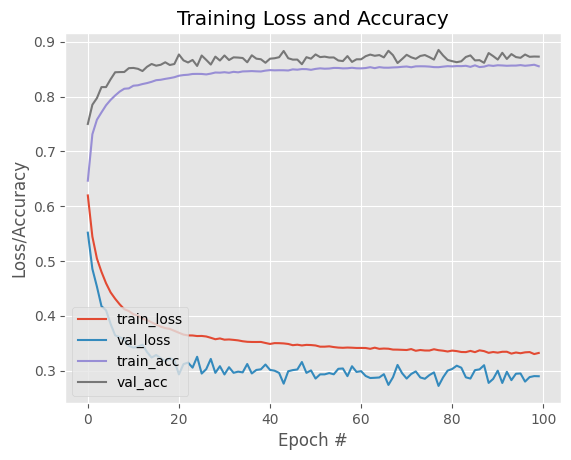

In [15]:
plot_training(history, plot_path)